In [163]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [164]:
print(tf.__version__)

2.5.0


# Loading SIPI Dataset

SIPI dataset was preprocessed using prepare_dataset notebook, so these three folders already contain Detritus/Non-Detritus images.

In [165]:
DatasetName = 'Multidataset-SIPI-A'

train_dir = DatasetName+'/train'
validation_dir =  DatasetName+'/val'
test_dir = DatasetName+'/test'

In [166]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

The three datasets are loaded using keras preprocessing method *image_dataset_from_directory*. Both the batch size and the image size hyperparameters where tested using different values. 

In [167]:
train_dataset = image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 34927 files belonging to 16 classes.
Found 7472 files belonging to 16 classes.
Found 7481 files belonging to 16 classes.


# Training

In [168]:
# Hyperparamers to be used in all models
base_learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
TRAINING_EPOCHS = 40
class_number = 16

# MobileNet model

A MobileNet model is loaded and modified so it can be used to predict Detritus images..

In [169]:
mobile_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [170]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = mobile_base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [171]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [172]:
prediction_layer = tf.keras.layers.Dense(17)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 17)


In [173]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = mobile_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

# DenseNet model

In [174]:
dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [175]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = dense_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
densenet_model = tf.keras.Model(inputs, outputs)

# VGG model

In [176]:
vgg_base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [177]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = vgg_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
vgg_model = tf.keras.Model(inputs, outputs)

# Inception Resnet model

In [178]:
inception_base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [179]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = inception_base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
inception_resnet_model = tf.keras.Model(inputs, outputs)

# Training models

In [180]:
def train_model(model, epochs):
    print("Training model, epochs: ", epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, training_loss, val_loss

In [181]:
def show_plot(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [182]:
import numpy
from sklearn import metrics

def show_report(model, generator):
    test_steps_per_epoch = numpy.math.ceil(generator.samples / generator.batch_size)
    predictions = mobilenet_model.predict(generator, steps=test_steps_per_epoch)
    
    y_pred = np.empty(len(predictions), dtype=float) 
    for i in range(len(predictions)):
        score = tf.nn.softmax(predictions[i])
        y_pred[i] = np.argmax(score)
    
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())   
    report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
    print(report)

We test each of the 4 models from scratch. Comparing them by the testing accuracy and analyzing their Training and Validation Accuracy/Loss along the training epochs
*MobileNet = 92.5% (99% training accuracy)

In [183]:
mobilenet_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_16 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_13  (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 17)                21777     
Total params: 2,279,761
Trainable params: 2,245,649
Non-trainable params: 34,112
___________________________________________

In [184]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(test_dir,
shuffle=False,
batch_size=BATCH_SIZE)

train_data_generator = test_generator.flow_from_directory(train_dir,
shuffle=False,
batch_size=BATCH_SIZE)

Found 7481 images belonging to 16 classes.
Found 34927 images belonging to 16 classes.


Training model, epochs:  40
Epoch 1/40
1092/1092 [==============================] - 130s 115ms/step - loss: 1.1809 - accuracy: 0.6239 - val_loss: 2.1716 - val_accuracy: 0.5055
Epoch 2/40
1092/1092 [==============================] - 132s 121ms/step - loss: 0.8000 - accuracy: 0.7207 - val_loss: 2.5939 - val_accuracy: 0.5055
Epoch 3/40
1092/1092 [==============================] - 123s 113ms/step - loss: 0.6680 - accuracy: 0.7615 - val_loss: 3.7142 - val_accuracy: 0.5055
Epoch 4/40
1092/1092 [==============================] - 126s 115ms/step - loss: 0.5744 - accuracy: 0.7958 - val_loss: 5.2122 - val_accuracy: 0.5055
Epoch 5/40
1092/1092 [==============================] - 134s 123ms/step - loss: 0.4928 - accuracy: 0.8245 - val_loss: 6.5642 - val_accuracy: 0.5055
Epoch 6/40
1092/1092 [==============================] - 123s 112ms/step - loss: 0.4351 - accuracy: 0.8418 - val_loss: 4.9610 - val_accuracy: 0.5091
Epoch 7/40
1092/1092 [==============================] - 124s 114ms/step - loss: 0.37

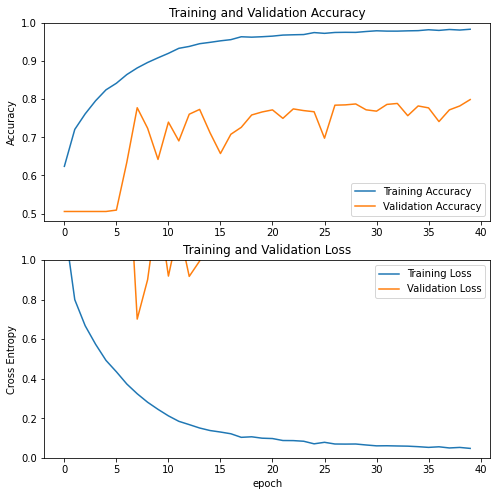

In [185]:
acc, val_acc, loss, val_loss = train_model(mobilenet_model, TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

In [186]:
show_report(mobilenet_model, test_data_generator)
show_report(mobilenet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.70      0.89      0.79      3778
           LClass_Appendic       0.73      0.21      0.32       393
     LClass_Appendic_Unfoc       0.71      0.02      0.05       403
      LClass_Cop_Calanoida       0.93      0.29      0.44       242
LClass_Cop_Calanoida_Unfoc       0.43      0.54      0.48       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.35      0.09      0.14       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.51      0.64      0.57       390
 LClass_Dino_Cer_Trip_Brev       0.15      0.40      0.22       141
          LClass_Filaments       0.42      0.66      0.51       532
    LClass_Filaments_Unfoc       0.44      0.30      0.36        89
        LClass_Nauplii_Cop       0.40      0.01

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Training model, epochs:  40
Epoch 1/40
1092/1092 [==============================] - 315s 265ms/step - loss: 0.7744 - accuracy: 0.7410 - val_loss: 0.8824 - val_accuracy: 0.7128
Epoch 2/40
1092/1092 [==============================] - 284s 260ms/step - loss: 0.5112 - accuracy: 0.8209 - val_loss: 1.2679 - val_accuracy: 0.6041
Epoch 3/40
1092/1092 [==============================] - 283s 259ms/step - loss: 0.4218 - accuracy: 0.8503 - val_loss: 2.4042 - val_accuracy: 0.2724
Epoch 4/40
1092/1092 [==============================] - 286s 262ms/step - loss: 0.3674 - accuracy: 0.8697 - val_loss: 0.5478 - val_accuracy: 0.8251
Epoch 5/40
1092/1092 [==============================] - 286s 262ms/step - loss: 0.3217 - accuracy: 0.8828 - val_loss: 0.6127 - val_accuracy: 0.8010
Epoch 6/40
1092/1092 [==============================] - 284s 260ms/step - loss: 0.2717 - accuracy: 0.9013 - val_loss: 0.7264 - val_accuracy: 0.7752
Epoch 7/40
1092/1092 [==============================] - 283s 259ms/step - loss: 0.23

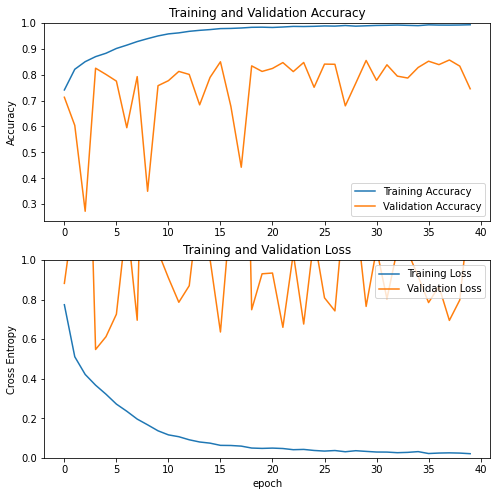

In [187]:
acc, val_acc, loss, val_loss = train_model(densenet_model, TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

In [188]:
show_report(densenet_model, test_data_generator)
show_report(densenet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.70      0.89      0.79      3778
           LClass_Appendic       0.73      0.21      0.32       393
     LClass_Appendic_Unfoc       0.71      0.02      0.05       403
      LClass_Cop_Calanoida       0.93      0.29      0.44       242
LClass_Cop_Calanoida_Unfoc       0.43      0.54      0.48       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.35      0.09      0.14       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.51      0.64      0.57       390
 LClass_Dino_Cer_Trip_Brev       0.15      0.40      0.22       141
          LClass_Filaments       0.42      0.66      0.51       532
    LClass_Filaments_Unfoc       0.44      0.30      0.36        89
        LClass_Nauplii_Cop       0.40      0.01

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Training model, epochs:  40
Epoch 1/40
1092/1092 [==============================] - 327s 280ms/step - loss: 0.7550 - accuracy: 0.7507 - val_loss: 0.6646 - val_accuracy: 0.7875
Epoch 2/40
1092/1092 [==============================] - 294s 269ms/step - loss: 0.4842 - accuracy: 0.8294 - val_loss: 0.5942 - val_accuracy: 0.8121
Epoch 3/40
1092/1092 [==============================] - 291s 266ms/step - loss: 0.3675 - accuracy: 0.8698 - val_loss: 0.6313 - val_accuracy: 0.7982
Epoch 4/40
1092/1092 [==============================] - 290s 265ms/step - loss: 0.2721 - accuracy: 0.9010 - val_loss: 0.9283 - val_accuracy: 0.7183
Epoch 5/40
1092/1092 [==============================] - 286s 262ms/step - loss: 0.1954 - accuracy: 0.9295 - val_loss: 0.9438 - val_accuracy: 0.7645
Epoch 6/40
1092/1092 [==============================] - 288s 264ms/step - loss: 0.1413 - accuracy: 0.9495 - val_loss: 0.8279 - val_accuracy: 0.7986
Epoch 7/40
1092/1092 [==============================] - 314s 288ms/step - loss: 0.10

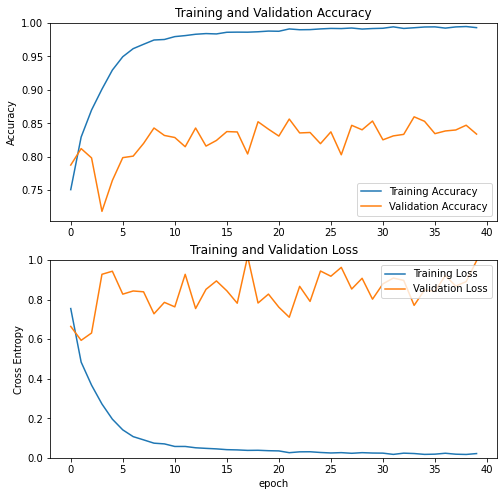

In [189]:
acc, val_acc, loss, val_loss = train_model(inception_resnet_model, TRAINING_EPOCHS)
show_plot(acc, val_acc, loss, val_loss)

In [190]:
show_report(inception_resnet_model, test_data_generator)
show_report(inception_resnet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.70      0.89      0.79      3778
           LClass_Appendic       0.73      0.21      0.32       393
     LClass_Appendic_Unfoc       0.71      0.02      0.05       403
      LClass_Cop_Calanoida       0.93      0.29      0.44       242
LClass_Cop_Calanoida_Unfoc       0.43      0.54      0.48       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.35      0.09      0.14       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.51      0.64      0.57       390
 LClass_Dino_Cer_Trip_Brev       0.15      0.40      0.22       141
          LClass_Filaments       0.42      0.66      0.51       532
    LClass_Filaments_Unfoc       0.44      0.30      0.36        89
        LClass_Nauplii_Cop       0.40      0.01

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

** Adicionar tabela com resultados

After comparing them we choose MobileNet as it demands a smaller number of parameters to train. We use techniques in order to improve Training and Validation accuracy.

# Transfer learning with freezing

We load the model again but with pre-set imagenet weights.

In [191]:
TRAINING_EPOCHS = 20

In [192]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

We achieve around 93% training accuracy and around 93% testing accuracy.

# Transfer learning without freezing

We load the model again but with pre-set imagenet weights.

In [193]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

We achieve around 99% training accuracy and around 95% testing accuracy.

# Transfer learning and Fine Tuning + Regularizatoin

# Data Augmentation

This adds random transformations to the training images in order to reduce overfitting.

In [194]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

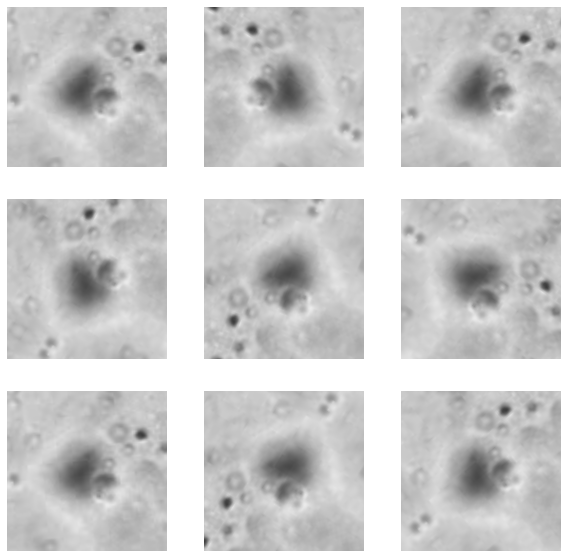

In [195]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Training

In [196]:
def train_model(model, initial_epochs, fine_tune_epochs, fine_tune_at, base_model):
    print("Training model, epochs: ", initial_epochs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    base_model.trainable = True
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
        layer.trainable =  False
        
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
    
    total_epochs =  initial_epochs + fine_tune_epochs

    print("Fine tuning, epochs: ", fine_tune_epochs)
    history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    
    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy)
    
    return acc, val_acc, loss, val_loss

# MobileNet model

In [197]:
mobile_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

mobile_base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = mobile_base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

# DenseNet model

In [198]:
dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

dense_base_model.trainable = False

preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = dense_base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
densetnet_model = tf.keras.Model(inputs, outputs)

# Inception Resnet model

In [199]:
inception_base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

inception_base_model.trainable = False

preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_number)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = inception_base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
inception_resnet_model = tf.keras.Model(inputs, outputs)

In [200]:
TRAINING_EPOCHS = 20

Training model, epochs:  20
Epoch 1/20


/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


1092/1092 [==============================] - 73s 63ms/step - loss: 1.1518 - accuracy: 0.6547 - val_loss: 0.7056 - val_accuracy: 0.7705
Epoch 2/20
1092/1092 [==============================] - 64s 59ms/step - loss: 0.6922 - accuracy: 0.7721 - val_loss: 0.5893 - val_accuracy: 0.8034
Epoch 3/20
1092/1092 [==============================] - 41s 37ms/step - loss: 0.6016 - accuracy: 0.7977 - val_loss: 0.5450 - val_accuracy: 0.8177
Epoch 4/20
1092/1092 [==============================] - 69s 63ms/step - loss: 0.5532 - accuracy: 0.8139 - val_loss: 0.5217 - val_accuracy: 0.8220
Epoch 5/20
1092/1092 [==============================] - 43s 39ms/step - loss: 0.5284 - accuracy: 0.8205 - val_loss: 0.5048 - val_accuracy: 0.8256
Epoch 6/20
1092/1092 [==============================] - 76s 69ms/step - loss: 0.5060 - accuracy: 0.8282 - val_loss: 0.4944 - val_accuracy: 0.8302
Epoch 7/20
1092/1092 [==============================] - 57s 52ms/step - loss: 0.4880 - accuracy: 0.8323 - val_loss: 0.4843 - val_accura

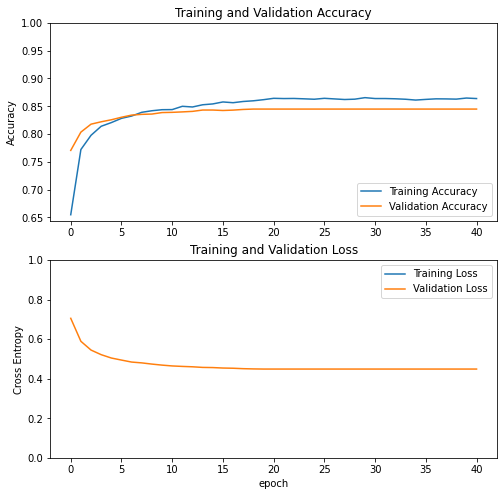

In [201]:
acc, val_acc, loss, val_loss = train_model(mobilenet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 100, mobile_base_model)
show_plot(acc, val_acc, loss, val_loss)

In [202]:
show_report(mobilenet_model, test_data_generator)
show_report(mobilenet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.74      0.83      0.78      3778
           LClass_Appendic       0.72      0.05      0.09       393
     LClass_Appendic_Unfoc       0.29      0.49      0.37       403
      LClass_Cop_Calanoida       0.65      0.25      0.36       242
LClass_Cop_Calanoida_Unfoc       0.16      0.42      0.23       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.00      0.00      0.00       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.29      0.25      0.27       390
 LClass_Dino_Cer_Trip_Brev       0.00      0.00      0.00       141
          LClass_Filaments       0.56      0.31      0.40       532
    LClass_Filaments_Unfoc       0.12      0.30      0.17        89
        LClass_Nauplii_Cop       0.00      0.00

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Training model, epochs:  20
Epoch 1/20
1092/1092 [==============================] - 151s 121ms/step - loss: 1.2607 - accuracy: 0.6465 - val_loss: 0.7397 - val_accuracy: 0.7707
Epoch 2/20
1092/1092 [==============================] - 129s 118ms/step - loss: 0.6963 - accuracy: 0.7822 - val_loss: 0.5977 - val_accuracy: 0.8055
Epoch 3/20
1092/1092 [==============================] - 120s 110ms/step - loss: 0.5952 - accuracy: 0.8089 - val_loss: 0.5420 - val_accuracy: 0.8208
Epoch 4/20
1092/1092 [==============================] - 151s 138ms/step - loss: 0.5486 - accuracy: 0.8215 - val_loss: 0.5114 - val_accuracy: 0.8306
Epoch 5/20
1092/1092 [==============================] - 128s 117ms/step - loss: 0.5176 - accuracy: 0.8285 - val_loss: 0.4894 - val_accuracy: 0.8355
Epoch 6/20
1092/1092 [==============================] - 124s 114ms/step - loss: 0.4962 - accuracy: 0.8351 - val_loss: 0.4749 - val_accuracy: 0.8394
Epoch 7/20
1092/1092 [==============================] - 118s 108ms/step - loss: 0.47

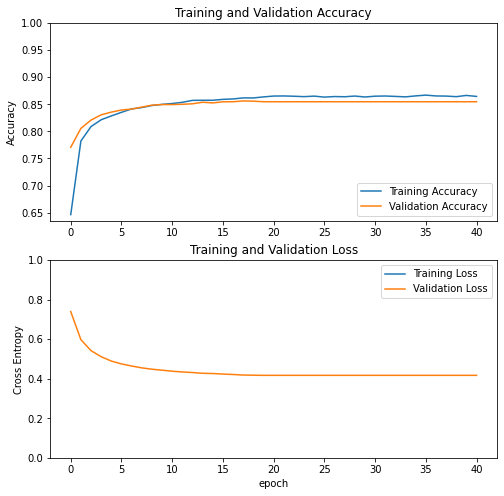

In [203]:
acc, val_acc, loss, val_loss = train_model(densetnet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 660, dense_base_model)
show_plot(acc, val_acc, loss, val_loss)

In [204]:
show_report(densetnet_model, test_data_generator)
show_report(densetnet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.74      0.83      0.78      3778
           LClass_Appendic       0.72      0.05      0.09       393
     LClass_Appendic_Unfoc       0.29      0.49      0.37       403
      LClass_Cop_Calanoida       0.65      0.25      0.36       242
LClass_Cop_Calanoida_Unfoc       0.16      0.42      0.23       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.00      0.00      0.00       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.29      0.25      0.27       390
 LClass_Dino_Cer_Trip_Brev       0.00      0.00      0.00       141
          LClass_Filaments       0.56      0.31      0.40       532
    LClass_Filaments_Unfoc       0.12      0.30      0.17        89
        LClass_Nauplii_Cop       0.00      0.00

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Training model, epochs:  20
Epoch 1/20
1092/1092 [==============================] - 154s 128ms/step - loss: 1.2920 - accuracy: 0.6447 - val_loss: 0.7757 - val_accuracy: 0.7579
Epoch 2/20
1092/1092 [==============================] - 142s 130ms/step - loss: 0.7966 - accuracy: 0.7544 - val_loss: 0.6526 - val_accuracy: 0.7875
Epoch 3/20
1092/1092 [==============================] - 131s 120ms/step - loss: 0.6993 - accuracy: 0.7768 - val_loss: 0.6070 - val_accuracy: 0.8017
Epoch 4/20
1092/1092 [==============================] - 135s 124ms/step - loss: 0.6545 - accuracy: 0.7882 - val_loss: 0.5764 - val_accuracy: 0.8113
Epoch 5/20
1092/1092 [==============================] - 141s 129ms/step - loss: 0.6179 - accuracy: 0.7986 - val_loss: 0.5538 - val_accuracy: 0.8168
Epoch 6/20
1092/1092 [==============================] - 127s 116ms/step - loss: 0.5893 - accuracy: 0.8075 - val_loss: 0.5456 - val_accuracy: 0.8185
Epoch 7/20
1092/1092 [==============================] - 136s 124ms/step - loss: 0.57

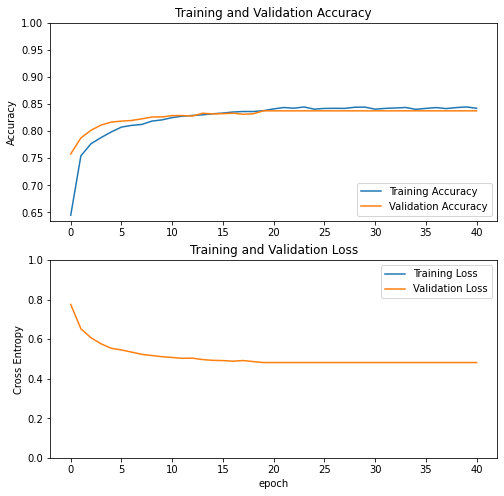

In [205]:
acc, val_acc, loss, val_loss = train_model(inception_resnet_model, TRAINING_EPOCHS, TRAINING_EPOCHS, 755, inception_base_model)
show_plot(acc, val_acc, loss, val_loss)

In [206]:
show_report(inception_resnet_model, test_data_generator)
show_report(inception_resnet_model, train_data_generator)

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

                            precision    recall  f1-score   support

                  Detritus       0.74      0.83      0.78      3778
           LClass_Appendic       0.72      0.05      0.09       393
     LClass_Appendic_Unfoc       0.29      0.49      0.37       403
      LClass_Cop_Calanoida       0.65      0.25      0.36       242
LClass_Cop_Calanoida_Unfoc       0.16      0.42      0.23       227
          LClass_Cop_Cyclo       0.00      0.00      0.00       195
    LClass_Cop_Cyclo_Unfoc       0.00      0.00      0.00       145
         LClass_Cop_Ecdise       0.00      0.00      0.00       100
   LClass_Dino_Cer_Fur_Lin       0.00      0.00      0.00        87
 LClass_Dino_Cer_Tric_Mass       0.29      0.25      0.27       390
 LClass_Dino_Cer_Trip_Brev       0.00      0.00      0.00       141
          LClass_Filaments       0.56      0.31      0.40       532
    LClass_Filaments_Unfoc       0.12      0.30      0.17        89
        LClass_Nauplii_Cop       0.00      0.00

/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmansilla/anaconda3/envs/python37/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_